In [1]:
import json
import requests
from datetime import date
import pandas as pd
import pygal
from IPython.display import SVG
import pprint

pp = pprint.PrettyPrinter(indent=4)

# As specified there: https://wikimedia.org/api/rest_v1/#/
# Without your contact details you'll get an error
contact_details = "a455bcd9 on Wikipedia / @ADssx on Twitter"
headers = {
    'User-Agent': contact_details
}

# Get all projects from the Wikimedia Foundation
projects_list_url = "https://commons.wikimedia.org/w/api.php?action=sitematrix&smtype=language&format=json"
projects_list_json = requests.get(projects_list_url, headers=headers).text

projects = json.loads(projects_list_json)

In [2]:
# Get list of all Wikipedias

wiki_codes = []
id = 0

# Look the whole list
for i in projects['sitematrix']:
    # Only fetch dictionnaries
    if isinstance(projects['sitematrix'][i],dict):
        # Get the language code
        code = projects['sitematrix'][i]['code']
        
        # Avoid issue with classical orthography Belarusian Wikipedia
        if code == 'be-x-old':
            continue

        # For each language, look at all different projects
        for j in projects['sitematrix'][i]['site']:
            # If the project is a Wikipedia, add the language code to the list of Wikipedias
            if j['code'] == 'wiki':
                wiki_codes += [code]

# For testing purposes set to True
if True:
    # Set to have unique languade codes in case there's a mistake in the list
    wiki_codes = set(['en', 'fr', 'de', 'es', 'ru', 'tr', 'ko', 'ja', 'ar', 'it', 'zh', 'arz', 'nl', 'pt', 'he'])

print('Analysis of', len(wiki_codes), 'Wikipedias')

Analysis of 15 Wikipedias


In [3]:
# Desired month

if True:
    # By default, use the last month
    today = date.today()

    year = today.year
    month = today.month - 1

    # Special case for January
    if today.month == 1:
        year = year - 1
        month = 12

    last_month = date(year, month, 1)
else:
    # Pick any other month
    last_month = date(2019, 5, 1)

# Convert to string to add to URL
point_in_time = last_month.strftime('%Y/%m')

print("Analyzed period:", point_in_time)

Analyzed period: 2021/01


In [4]:
# For each Wikipedia, get the number of page views in the analyzed month

# API example: https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/fr.wikipedia/all-access/2021/01
base_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/"

all_wikipedias = pd.DataFrame(columns=['country'])

for code in wiki_codes:
    # For each Wikipedia get the list of page views by country
    project = code + ".wikipedia"

    countries_url = base_url + project + "/all-access/" + point_in_time

    countries_json = requests.get(countries_url, headers=headers).text

    countries = json.loads(countries_json)
    
    # Transform to a dataframe
    df = pd.DataFrame.from_dict(countries['items'][0]['countries'])

    # Drop useless columns
    df = df.drop(columns=['views', 'rank'])

    # Rename one column
    df = df.rename(columns={"views_ceil": code})

    # Merging the dataframes on the country key with outer join
    all_wikipedias = pd.merge(all_wikipedias, df, how="outer", on="country")

# Set the country code as index
all_wikipedias = all_wikipedias.set_index("country")

In [5]:
# Get the most popular Wikipedia by country
most_popular_by_country = all_wikipedias.idxmax(axis=1)

# Add back the index
most_popular_by_country = most_popular_by_country.reset_index()

# Rename the column
most_popular_by_country = most_popular_by_country.rename(columns={0: "most_popular"})

# Number of countries where each edition is top
popular_wikipedias = most_popular_by_country.groupby(['most_popular']).count()
# Sort by number of countries where language is first
popular_wikipedias = popular_wikipedias.sort_values(by=['country'], ascending=False)

# Languages that are number one in at least one country
top_languages = set(most_popular_by_country["most_popular"])
print(top_languages)
print("There are", len(top_languages), "top languages")

# Names of countries where each edition arrives first
# We concatenate country codes
# https://stackoverflow.com/a/22221675/5285608
countries_by_language = most_popular_by_country.groupby('most_popular')['country'].apply(list).to_dict()

{'ko', 'it', 'nl', 'ru', 'es', 'en', 'ja', 'tr', 'pt', 'ar', 'zh', 'de', 'he', 'fr'}
There are 14 top languages


8 languages #1 in at least 4 countries


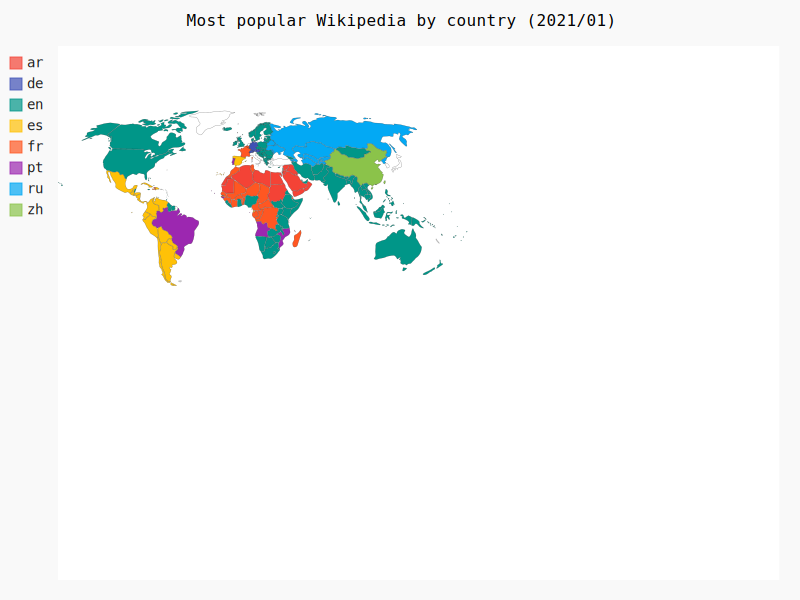

In [6]:
# Display the map of top countries
def display_svg(svg_code):
     return SVG(svg_code)

worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = 'Most popular Wikipedia by country (' + point_in_time + ')'

c = 0
for language in countries_by_language:
    # Threshold to appear on the map
    map_threshold = 3
    if len(countries_by_language[language]) > map_threshold:
        # Increase the count
        c += 1
        # Add countries and languages to the map
        worldmap_chart.add(language, [x.lower() for x in countries_by_language[language]])

print(c, "languages #1 in at least", map_threshold + 1, "countries")

# Save in a file
# javascript should be removed to allow upload on Wikimedia, maybe with add_scripts()?
# In the meantime, remove manually after export
worldmap_chart.render_to_file('chart.svg')

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

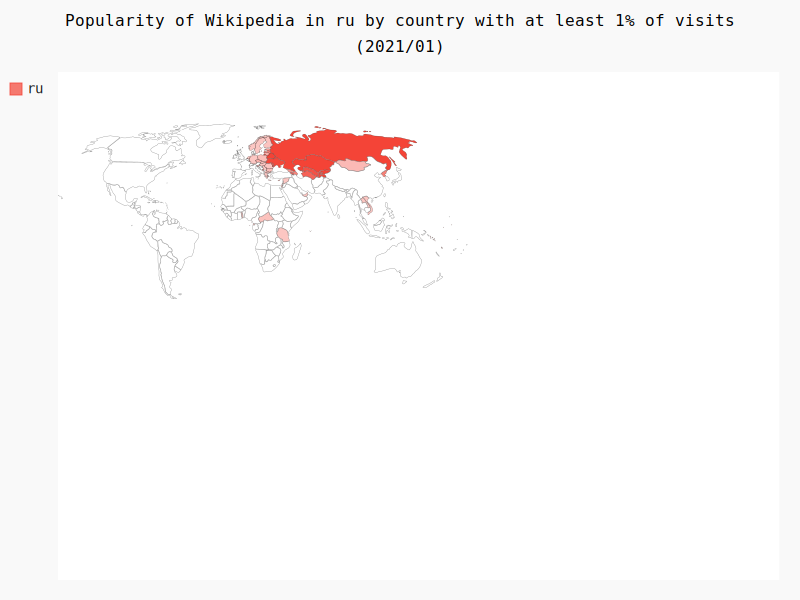

In [7]:
# For a given language, world map with color scale based on its use

# Percentage instead of absolute numbers
# https://stackoverflow.com/a/42006745/5285608
all_wikipedias_relative = all_wikipedias[all_wikipedias.columns].div(all_wikipedias[all_wikipedias.columns].sum(axis=1), axis=0).multiply(100)

# Language to display
language_code = "ru"

worldmap_chart = pygal.maps.world.World()
# Threshold in percentage
threshold = 1
worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country with at least ' + str(threshold) + '% of visits (' + point_in_time + ')'

language_relative = all_wikipedias_relative[language_code].to_dict()

# Country codes to lowercase & filtering based on threshold
language_relative = {key.lower(): value for key, value in language_relative.items() if value > threshold}

# Add to the map
worldmap_chart.add(language_code, language_relative)

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

{'tr': 0.0, 'se': 1.0, 'ae': 1.0, 'ir': 1.0, 'dz': 2.0, 'sa': 2.0, 'eg': 2.0, 'pk': 1.0, 'ma': 1.0, 'ng': 1.0, 'iq': 2.0, 'kw': 2.0, 'qa': 1.0, 'tn': 1.0, 'jo': 2.0, 'et': 1.0, 'om': 2.0, 'bj': 0.0, 'lb': 1.0, 'ly': 2.0, 'bh': 1.0, 'gh': 0.0, 'sn': 0.0, 'cm': 0.0, 'ci': 0.0, 'sy': 2.0, 'ps': 2.0, 'sd': 2.0, 'gn': 0.0, 'so': 1.0, 'ss': 1.0, 'af': 1.0, 'bf': 0.0, 'ye': 2.0, 'er': 1.0, 'cg': 0.0, 'mr': 2.0, 'sz': 0.0, 'bi': 0.0, 'ml': 0.0, 'gm': 1.0, 'ne': 0.0, 'sl': 0.0, 'dj': 0.0, 'td': 1.0, 'lr': 0.0, 'vc': 1.0, 'vi': 0.0, 'km': 0.0, 'vg': 0.0, 'eh': 2.0}


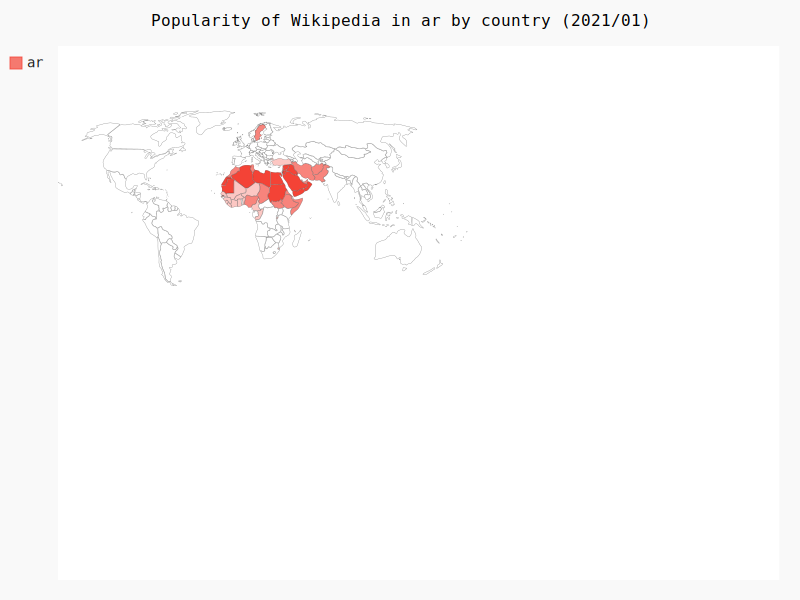

In [9]:
# For a given language, simplied world map to display countries where it is ranked at least nth

# Language to display
language_code = "ar"

worldmap_chart = pygal.maps.world.World()

worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country (' + point_in_time + ')'

# Rank languages by pageviews in each country
all_wikipedias_ranked = all_wikipedias.rank(axis=1, method='min', ascending=False)
language_ranked = all_wikipedias_ranked[language_code].to_dict()

# We display only countries where rank >= threshold
threshold = 3

# Country codes to lowercase & filtering based on threshold &
# invert ranking for correct gradien display in pygal
language_ranked = {key.lower(): (abs(value - threshold)) for key, value in language_ranked.items() if value <= threshold}

print(language_ranked)

# Add to the map
worldmap_chart.add(language_code, language_ranked)

# Save to file
filename = language_code + '_rank_' + point_in_time.replace('/', '_') + '_chart.svg'
worldmap_chart.render_to_file(filename)

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

In [ ]:
# Future developments:
# Get history by country
# Fix the issue of South Sudan, Isle of Man and other missing countries